In [1]:
from download_data import *
from main import *
from get_goes import *
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from pyresample import create_area_def
from satpy import Scene
from satpy.writers import get_enhanced_image
import os
import skimage
import numpy as np
import pytz
from datetime import timedelta
import glob

In [2]:
dt_str = '2024/02/24 22:50'
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M')) # convert to datetime object

In [3]:
for_a_dt(dt)

['ABI-L1b-RadF/2024/055/22/OR_ABI-L1b-RadF-M6C14_G16_s20240552250205_e20240552259513_c20240552259562.nc', 'ABI-L1b-RadF/2024/055/22/OR_ABI-L1b-RadF-M6C15_G16_s20240552250205_e20240552259519_c20240552259571.nc', 'ABI-L1b-RadF/2024/055/22/OR_ABI-L1b-RadF-M6C16_G16_s20240552250205_e20240552259525_c20240552259568.nc', 'ABI-L2-ACHTF/2024/055/22/OR_ABI-L2-ACHTF-M6_G16_s20240552250205_e20240552259513_c20240552303161.nc']
[]
[]


In [4]:
goes_dl_loc = get_goes_dl_loc(dt.year, str(dt.timetuple().tm_yday).zfill(3))
sample_list = get_sample_list(goes_dl_loc)
files_for_sample = sample_list[0]
print(files_for_sample)

['/scratch/alpine/mecr8410/Cloud_Top_Temp/GOES/2024/055/OR_ABI-L1b-RadF-M6C14_G16_s20240552250205_e20240552259513_c20240552259562.nc', '/scratch/alpine/mecr8410/Cloud_Top_Temp/GOES/2024/055/OR_ABI-L1b-RadF-M6C15_G16_s20240552250205_e20240552259519_c20240552259571.nc', '/scratch/alpine/mecr8410/Cloud_Top_Temp/GOES/2024/055/OR_ABI-L1b-RadF-M6C16_G16_s20240552250205_e20240552259525_c20240552259568.nc', '/scratch/alpine/mecr8410/Cloud_Top_Temp/GOES/2024/055/OR_ABI-L2-ACHTF-M6_G16_s20240552250205_e20240552259513_c20240552303161.nc']


In [5]:
def get_extent():
    x0 = -2.4e6
    y0 = -2.112e6
    x1 = 1.696e6
    y1 = 1.984e6
    return [x0, y0, x1, y1]

def get_lcc_proj():
    lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                    central_latitude=38.5,
                                    standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                    semiminor_axis=6371229))
    return lcc_proj

def get_scn(fns, to_load, extent, res=2000, reader='abi_l1b'):
    scn = Scene(reader=reader, filenames=fns)
    scn.load(to_load, generate=False)
    my_area = create_area_def(area_id='lccCONUS',
                              description='Lambert conformal conic for the contiguous US',
                              projection=get_lcc_proj(),
                              resolution=res,
                              area_extent=extent
                              )
    new_scn = scn.resample(my_area) # resamples datasets and resturns a new scene object
    return new_scn

def get_scns(sat_fns):
    sat_fns = list(set(sat_fns))
    sat_fns.sort()
    fn_head = sat_fns[0].split('C14_')[-1].split('.')[0].split('_e2')[0]
    bands = ['C14', 'C15', 'C16']
    extent = get_extent()
    scn = get_scn(sat_fns[:-1], bands, extent) # get satpy scn object
    temp_scn = get_scn([sat_fns[-1]], ['TEMP'], extent, reader='abi_l2_nc') # get satpy scn object
    return scn, temp_scn

In [6]:
scn, temp_scn = get_scns(files_for_sample)

In [7]:
def normalize(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))

def get_IR(scn, bands):
    C14 = scn[bands[0]].compute().data
    #C14 = normalize(C14)
    C15 = scn[bands[1]].compute().data
    #C15 = normalize(C15)
    C16 = scn[bands[2]].compute().data
    #C16 = normalize(C16)
    IR = np.dstack([C14, C15, C16])
    IR[np.isnan(IR)] = 0
    return C14, C15, C16

bands = ['C14', 'C15', 'C16']
C14, C15, C16 = get_IR(scn, bands)

/projects/mecr8410/software/anaconda/envs/g2g/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/projects/mecr8410/software/anaconda/envs/g2g/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


In [14]:
C14 = scn['C14'].compute().data
#C14 = normalize(C14)
C15 = scn['C15'].compute().data
#C15 = normalize(C15)
C16 = scn['C16'].compute().data

In [19]:
def get_stats_dict(month, band, sat='G16'):
    pkl_loc = "../percentiles/data_pkls/{}/percentile_stats_{}_{}_2024_{}.pkl".format(band, sat, band, str(month).zfill(2))
    print(pkl_loc)
    with open(pkl_loc, 'rb') as f:
        stats_dict = pickle.load(f)
    return stats_dict

def clip_scale_percentile(data, min_p, max_p):
    scaled = (data - min_p) / (max_p - min_p)
    clipped = np.clip(scaled, 0, 1)
    return clipped
C14_stats = get_stats_dict(dt.month, 'C14')
C14 = scale_percentile(C14, C14_stats['percentiles'][1], C14_stats['percentiles'][99])

../percentiles/data_pkls/C14/percentile_stats_G16_C14_2024_02.pkl


In [37]:
%matplotlib inline
def plot_CONUS(data, crs, name):
    #states = get_states(crs) # ./scripts/helper_functions.py
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')
    #states.boundary.plot(ax=ax, edgecolor='white', linewidth=.25)
    plt.axis('off')
    fig.tight_layout()
    #plt.savefig('{}.png'.format(name))
    plt.show()    

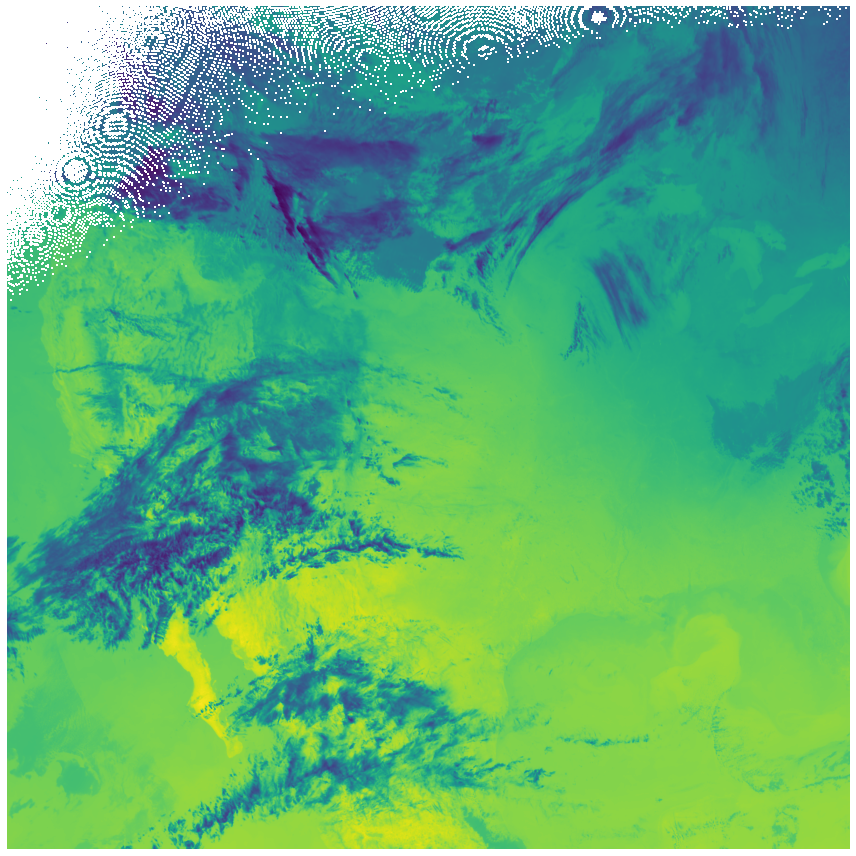

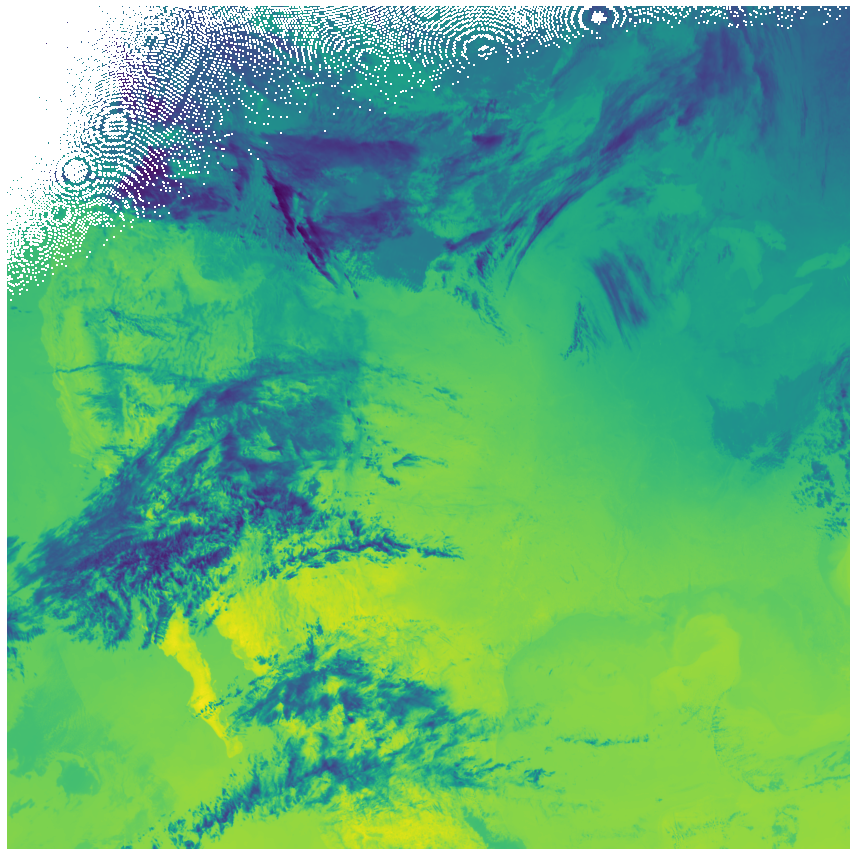

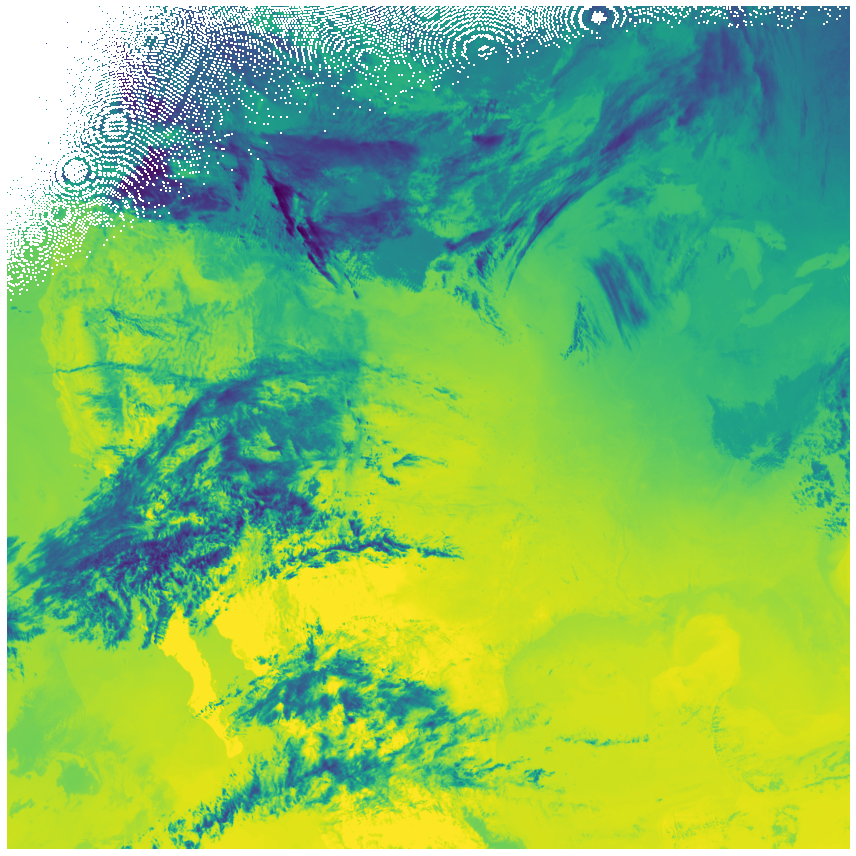

In [38]:
plot_CONUS(C14, crs, 'C14')
plot_CONUS(C14_scale, crs, 'C14_scale')
plot_CONUS(np.clip(C14_scale, 0, 1), crs, 'C14_scale_clip')

In [35]:


def get_temp(temp_scn):
    temp = temp_scn['TEMP'].compute().data
    temp[np.isnan(temp)] = 0
    temp[(temp<233) & (temp>0)]= 3 # high
    temp[(temp>=233) & (temp<=253)] = 2 # mid
    temp[(temp>253)] = 1 # low
    temp = np.array(temp, dtype=np.int8)
    therm_mask = thermometer_encode(temp)
    return therm_mask
    #one_hot_mask = get_one_hot(temp) # from the scene object, extract RGB data for plotting
    #return one_hot_mask

def thermometer_encode(x, num_cats=3):
    # n_cats is 3 because [0, 0, 0] is no cloud (ground)
    # [0, 0, 1] is low cloud [1, 1, 1] is high cloud
    flat = x.flatten()
    encoded = (np.arange(num_cats) < flat[:, None]).astype(int)
    return encoded.reshape(*x.shape, num_slots)

def get_one_hot(cat_encode, n_cats=4):
    k = np.take(np.eye(n_cats), cat_encode, axis=1)
    k = k[1:,:,:]
    k = np.einsum('ijk->jki', k)
    return k 

def split_img(full_image, img_size=1024):
    n_row = int(full_image.shape[0]/img_size)
    n_col = int(full_image.shape[1]/img_size)
    full_image = full_image[0:int(n_row*img_size),0:int(n_col*img_size)][:]
    fig, ax = plt.subplots(n_row, n_col, figsize=(n_col*3,n_row*3))
    for row in range(n_row):
        for col in range(n_col):
            ax[row][col].imshow(full_image[int(row*img_size):int((row+1)*img_size),int(col*img_size):int((col+1)*img_size)][:])
            ax[row][col].set_yticks([])
            ax[row][col].set_xticks([])
    plt.axis('off')
    fig.tight_layout()
    plt.show()
    
